In [1]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import gc
import time, os
%matplotlib inline
%load_ext Cython
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')
import matplotlib.pyplot as plt
import json

In [3]:
from __future__ import division, print_function
def deca_load(filename):
    tic = time.time()
    csv_path = 'data_raw/{}.csv'.format(filename)
    hdf_path = 'data_hdf/_{}.h5'.format(filename)
    if os.path.exists(hdf_path):
        print('loading {}... '.format(hdf_path), end='')
        result = pd.read_hdf(hdf_path)
        print("OK ({0:.1f}s)".format(time.time() - tic))
        return result
    else:
        try:
            os.mkdir('data_hdf')
        except:
            pass
        print('loading {}... '.format(csv_path), end='')
        result = pd.read_csv(csv_path)
        print("OK ({0:.1f}s)".format(time.time() - tic))
        result.to_hdf(hdf_path, 'fixed', mode='w', complib='blosc', complevel=9)
        print('Saved {} for fast future loading.'.format(hdf_path))
        return result
def deca_save(data, filename):
    tic = time.time()
    hdf_path = 'data_hdf/_{}.h5'.format(filename)
    print('saving {}... '.format(hdf_path), end='')
    data.to_hdf(hdf_path, 'fixed', mode='w', complib='blosc', complevel=9)
    print("OK ({0:.1f}s)".format(time.time() - tic))
def calc_loss(y, yp, opt=True):
    if opt:
        yp = 1.0 / (1.0 + np.exp(-yp))
    yp = np.clip(yp, 1e-7, 1-1e-7)
    loss_fn = y*np.log(yp)
    loss_fp = (1-y)*np.log(1-yp)
    return np.sum(-(5*loss_fn+loss_fp))/y.shape[0]

In [4]:
split_pathway = False #or full tables

In [5]:
if split_pathway:
    train_split = deca_load('train_split').reset_index(drop=True)
#     train_split.drop('one_last_ad', axis=1, inplace=True)
#     train_split.drop('second_last_ad', axis=1, inplace=True)
    valid_split = deca_load('valid_split').reset_index(drop=True)
#     valid_split.drop('one_last_ad', axis=1, inplace=True)
#     valid_split.drop('second_last_ad', axis=1, inplace=True)
else:
    full_train_table = deca_load('train_interactions').reset_index(drop=True)
#     full_train_table.drop('one_last_ad', axis=1, inplace=True)
#     full_train_table.drop('second_last_ad', axis=1, inplace=True)
    test = deca_load('test').reset_index(drop=True)
#     test.drop('one_last_ad', axis=1, inplace=True)
#     test.drop('second_last_ad', axis=1, inplace=True)

loading data_hdf/_train_interactions.h5... OK (6.8s)
loading data_hdf/_test.h5... OK (0.2s)


In [6]:
# !ls data_hdf/*encoded.h5

In [7]:
# !ls data_hdf/*encoded_ftrn.h5

In [8]:
augFeatures = [('user_id_last_click_2nd_diff_encoded', 0), ('user_id_last_click_3rd_diff_encoded', 0), 
               ('user_id_last_click_4th_diff_encoded', 0), ('user_id_last_click_5th_diff_encoded', 0),
               ('user_id_movAvgRt_encoded', 0),
               ('C1_encoded', 1), ('C2_encoded', 1), ('C3_encoded', 1), ('C4_encoded', 1), ('C5_encoded', 1), ('C6_encoded', 1), 
               ('uid_encoded', 0), ('icon_hash_encoded', 1), 
               ('icon_kmeans250_encoded', 1), ('icon_kmeans500_encoded', 1), 
               ('notif_kmeans_encoded', 1), ('notif_kmeans520_encoded', 0), 
               ('notifC_encoded', 1), ('sentenceC_encoded', 1), 
               ('notif_time_bin_encoded', 1), ('notif_send_hour_encoded', 0), ('words_count_encoded', 0),
               ('u1s_kmeans199_encoded', 1), ('u2s_kmeans299_encoded', 1)
              ]
if split_pathway:
    for feat, incfeat in augFeatures:
        if incfeat:
            train_split[feat] = deca_load(feat)
            valid_split[feat] = deca_load('{}_val'.format(feat))
        else:
            print('Skipped {}'.format(feat))
else:
    for feat, incfeat in augFeatures:
        if incfeat:
            full_train_table[feat] = deca_load('{}_ftrn'.format(feat))
            test[feat] = deca_load('{}_tst'.format(feat))
        else:
            print('Skipped {}'.format(feat))

Skipped user_id_last_click_2nd_diff_encoded
Skipped user_id_last_click_3rd_diff_encoded
Skipped user_id_last_click_4th_diff_encoded
Skipped user_id_last_click_5th_diff_encoded
Skipped user_id_movAvgRt_encoded
loading data_hdf/_C1_encoded_ftrn.h5... OK (2.3s)
loading data_hdf/_C1_encoded_tst.h5... OK (0.3s)
loading data_hdf/_C2_encoded_ftrn.h5... OK (1.1s)
loading data_hdf/_C2_encoded_tst.h5... OK (0.1s)
loading data_hdf/_C3_encoded_ftrn.h5... OK (2.1s)
loading data_hdf/_C3_encoded_tst.h5... OK (0.2s)
loading data_hdf/_C4_encoded_ftrn.h5... OK (2.1s)
loading data_hdf/_C4_encoded_tst.h5... OK (0.2s)
loading data_hdf/_C5_encoded_ftrn.h5... OK (2.2s)
loading data_hdf/_C5_encoded_tst.h5... OK (0.2s)
loading data_hdf/_C6_encoded_ftrn.h5... OK (1.7s)
loading data_hdf/_C6_encoded_tst.h5... OK (0.2s)
Skipped uid_encoded
loading data_hdf/_icon_hash_encoded_ftrn.h5... OK (1.2s)
loading data_hdf/_icon_hash_encoded_tst.h5... OK (0.2s)
loading data_hdf/_icon_kmeans250_encoded_ftrn.h5... OK (2.0s)
lo

In [9]:
cols = [u'last_click_1st', u'last_click_2nd', u'last_click_2nd_diff',
       u'last_click_3rd', u'last_click_3rd_diff', u'last_click_4th',
       u'last_click_4th_diff', u'last_click_5th_diff', u'movAvgRt',
       u'prev_3hours_imps', u'prev_day_imps', u'prev_hour_imps', u'prev_nid',
       u'prev_time_diff', u'next_3hours_imps', u'next_day_imps',
       u'next_hour_imps', u'next_nid', u'next_time_diff']
if split_pathway:
    train_split = pd.concat([train_split, deca_load('history_train')[cols]], axis=1)
    valid_split = pd.concat([valid_split, deca_load('history_valid')[cols]], axis=1)
else:
    full_train_table = pd.concat([full_train_table, deca_load('history_ftrain')[cols]], axis=1)
    test = pd.concat([test, deca_load('history_test')[cols]], axis=1)

loading data_hdf/_history_ftrain.h5... OK (52.3s)
loading data_hdf/_history_test.h5... OK (8.0s)


In [10]:
notifs_orig = deca_load('notifs_table_augmented')

loading data_hdf/_notifs_table_augmented.h5... OK (0.3s)


In [11]:
notifs = notifs_orig[['notif_id', 'sentenceC', 'words_count', 
                      'notifC', 'notif_kmeans', 'icon_kmeans250', 'notif_time_raw']]

if split_pathway:
    VsvdSplitOrig = deca_load('VsvdSplitScaled').iloc[:,:2]
    notifs = pd.merge(notifs, VsvdSplitOrig, how='left', left_on='notif_id', right_index=True)
else:
    VsvdSplitOrig = deca_load('VsvdFullScaled').iloc[:,:2]
    notifs = pd.merge(notifs, VsvdSplitOrig, how='left', left_on='notif_id', right_index=True)

# 'notif_send_dow', 'notif_send_hour', 'notif_time_bin'

loading data_hdf/_VsvdFullScaled.h5... OK (2.8s)


In [12]:
users_table_orig = deca_load('users_table_augmented')

loading data_hdf/_users_table_augmented.h5... OK (8.4s)


In [ ]:
users_table = users_table_orig #temp

In [13]:
users_table = users_table_orig[['user_id', 'N1', 'N2', 'N3'] + \
                          ['S1avg', 'S1std', 'S1max', 'S1notNA', 'S2avg', 'S2std', 'S2max', 'S2notNA', 'S1mad', 'S2mad'] + \
                          ['S1_PCA1', 'S1_PCA2', 'S2_PCA1', 'S2_PCA2', 'S2_PCA3', 'S1_PCA_KMEANS234', 'S2_PCA_KMEANS189']]
if split_pathway:
    UsvdSplitOrig = deca_load('UsvdSplitScaled').iloc[:,:2]
    users_table = pd.merge(users_table, UsvdSplitOrig, how='left', left_on='user_id', right_index=True)
else:
    UsvdSplitOrig = deca_load('UsvdFullScaled').iloc[:,:2]
    users_table = pd.merge(users_table, UsvdSplitOrig, how='left', left_on='user_id', right_index=True)

loading data_hdf/_UsvdFullScaled.h5... OK (3.2s)


In [15]:
%%time
if split_pathway:
    train_split = pd.merge(train_split, notifs, how='left', on='notif_id')
    valid_split = pd.merge(valid_split, notifs, how='left', on='notif_id')
    train_split = pd.merge(train_split, users_table, how='left', on='user_id')
    valid_split = pd.merge(valid_split, users_table, how='left', on='user_id')
#     y_trn = train_split.interaction.values
#     y_val = valid_split.interaction.values
else:
    full_train_table = pd.merge(full_train_table, notifs, how='left', on='notif_id')
    test = pd.merge(test, notifs, how='left', on='notif_id')
    full_train_table = pd.merge(full_train_table, users_table, how='left', on='user_id')
    test = pd.merge(test, users_table, how='left', on='user_id')
#     y_ftrn = full_train_table.interaction.values
#     y_tst = np.zeros(test.shape[0]).astype(int)

CPU times: user 2min 45s, sys: 1min 54s, total: 4min 40s
Wall time: 4min 40s


## Selecting features

In [70]:
if split_pathway:
    train_split['USVD0_qcut'], retbins = pd.qcut(train_split.USVD0, 10, labels=False, retbins=True)
    valid_split['USVD0_qcut'] = pd.cut(valid_split.USVD0, bins=retbins, labels=False, include_lowest=True)
    train_split['USVD1_qcut'], retbins = pd.qcut(train_split.USVD1, 10, labels=False, retbins=True)
    valid_split['USVD1_qcut'] = pd.cut(valid_split.USVD1, bins=retbins, labels=False, include_lowest=True)
    train_split['last_click_2nd_diff_qcut'], retbins = pd.qcut(train_split.last_click_2nd_diff, 5, labels=False, retbins=True)
    valid_split['last_click_2nd_diff_qcut'] = pd.cut(valid_split.last_click_2nd_diff, bins=retbins, labels=False, include_lowest=True)
    train_split['last_click_3rd_diff_qcut'], retbins = pd.qcut(train_split.last_click_3rd_diff, 5, labels=False, retbins=True)
    valid_split['last_click_3rd_diff_qcut'] = pd.cut(valid_split.last_click_3rd_diff, bins=retbins, labels=False, include_lowest=True)
    train_split['VSVD0_qcut'], retbins = pd.qcut(train_split.VSVD0, 6, labels=False, retbins=True)
    valid_split['VSVD0_qcut'] = pd.cut(valid_split.VSVD0, bins=retbins, labels=False, include_lowest=True)
else:
    full_train_table['USVD0_qcut'], retbins = pd.qcut(full_train_table.USVD0, 5, labels=False, retbins=True)
    test['USVD0_qcut'] = pd.cut(test.USVD0, bins=retbins, labels=False, include_lowest=True)
    full_train_table['USVD1_qcut'], retbins = pd.qcut(full_train_table.USVD1, 5, labels=False, retbins=True)
    test['USVD1_qcut'] = pd.cut(test.USVD1, bins=retbins, labels=False, include_lowest=True)
    full_train_table['last_click_2nd_diff_qcut'], retbins = pd.qcut(full_train_table.last_click_2nd_diff, 5, labels=False, retbins=True)
    test['last_click_2nd_diff_qcut'] = pd.cut(test.last_click_2nd_diff, bins=retbins, labels=False, include_lowest=True)
    full_train_table['last_click_3rd_diff_qcut'], retbins = pd.qcut(full_train_table.last_click_3rd_diff, 5, labels=False, retbins=True)
    test['last_click_3rd_diff_qcut'] = pd.cut(test.last_click_3rd_diff, bins=retbins, labels=False, include_lowest=True)
    full_train_table['VSVD0_qcut'], retbins = pd.qcut(full_train_table.VSVD0, 6, labels=False, retbins=True)
    test['VSVD0_qcut'] = pd.cut(test.VSVD0, bins=retbins, labels=False, include_lowest=True)

In [71]:
features = [['C1_encoded', 'C2_encoded', 'C3_encoded', 'C4_encoded', 'C5_encoded', 'C6_encoded', 
            'N1', 'N2', 'N3', 'S1_PCA1', 'S1_PCA2', 'S1mad', 'S1max', 'S1notNA', 'S1std', 
            'S2_PCA1', 'S2_PCA2', 'S2_PCA3', 'S2mad', 'S2notNA', 'S2std', 'notifC_encoded', 
            'notif_kmeans_encoded', 'words_count'], #0.643072, 0.619594
            ['prev_day_imps', 'next_day_imps'], #0.63996, 0.616303
            ['prev_time_diff', 'next_time_diff'], #0.635992, 0.624396
#             ['next_time_diff'] #0.677877,0.61748
#             ['u1s_kmeans199_encoded']#, 'u2s_kmeans299_encoded'], #0.63871, 0.615916
            ['u1s_kmeans199_encoded'],
            ['notifC'],
            ['USVD0_qcut'],
#             ['last_click_1st', 'last_click_2nd'],
            ['icon_kmeans500_encoded'], #0.629615, 0.615468
            ['notif_time_bin_encoded'],
#             ['last_click_2nd_diff'], #0.597704, 0.608079
#             ['last_click_2nd_diff_qcut', 'last_click_3rd_diff_qcut']
           ]

features = [item for sublist in features for item in sublist] #flatten

features = sorted(list(set(features)))
print('Features included: {}'.format(', '.join(features)))                           
print()

if split_pathway:
    missing = sorted(list(set(features) - set(train_split.columns)))
    notincluded = sorted(list(set(train_split.columns) - set(features)))
else:
    missing = sorted(list(set(features) - set(test.columns)))
    notincluded = sorted(list(set(test.columns) - set(features)))
if missing:
    print('Missing feature (causing error): {}\n'.format(', '.join(missing)))
print('Features not included: {}'.format(', '.join(notincluded)))                           

Features included: C1_encoded, C2_encoded, C3_encoded, C4_encoded, C5_encoded, C6_encoded, N1, N2, N3, S1_PCA1, S1_PCA2, S1mad, S1max, S1notNA, S1std, S2_PCA1, S2_PCA2, S2_PCA3, S2mad, S2notNA, S2std, USVD0_qcut, icon_kmeans500_encoded, next_day_imps, next_time_diff, notifC, notifC_encoded, notif_kmeans_encoded, notif_time_bin_encoded, prev_day_imps, prev_time_diff, u1s_kmeans199_encoded, words_count

Features not included: S1_PCA_KMEANS234, S1avg, S2_PCA_KMEANS189, S2avg, S2max, USVD0, USVD1, USVD1_qcut, VSVD0, VSVD0_qcut, VSVD1, icon_hash_encoded, icon_kmeans250, icon_kmeans250_encoded, last_click_1st, last_click_2nd, last_click_2nd_diff, last_click_2nd_diff_qcut, last_click_3rd, last_click_3rd_diff, last_click_3rd_diff_qcut, last_click_4th, last_click_4th_diff, last_click_5th_diff, movAvgRt, next_3hours_imps, next_hour_imps, next_nid, notif_id, notif_kmeans, notif_time_raw, prev_3hours_imps, prev_hour_imps, prev_nid, sentenceC, sentenceC_encoded, u2s_kmeans299_encoded, user_id


In [72]:
%%time
if split_pathway:
    X_trn = train_split[features].values
    X_val = valid_split[features].values
    y_trn = train_split.interaction.values
    y_val = valid_split.interaction.values
#     del train_split, valid_split, users_table
#     gc.collect()
else:
    X_ftrn = full_train_table[features].values
    X_tst = test[features].values
    y_ftrn = full_train_table.interaction.values
    y_tst = np.zeros(test.shape[0]).astype(int)
    gc.collect()

CPU times: user 14.4 s, sys: 21.2 s, total: 35.6 s
Wall time: 35.6 s


# LightGBM

In [76]:
%%time
# 'notif_kmeans'
# categoricals = ['one_last_ad', 'second_last_ad']
categoricals = None
categoricals = ['notifC']
if split_pathway:
    lgb_train = lgb.Dataset(X_trn, y_trn, feature_name=features, categorical_feature=categoricals)#, free_raw_data=True)
    lgb_eval = lgb.Dataset(X_val, y_val, feature_name=features, categorical_feature=categoricals, reference=lgb_train)#, free_raw_data=True)
else:
    lgb_ftrain = lgb.Dataset(X_ftrn, y_ftrn, feature_name=features, categorical_feature=categoricals)
    lgb_test = lgb.Dataset(X_tst, y_tst, feature_name=features, categorical_feature=categoricals, reference=lgb_ftrain)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 123 µs


In [77]:
params = {
    'task': 'train',
    'objective': 'none',
    'boosting': 'gbdt',
    'metric': 'auc',
    'train_metric': '+',
    'num_leaves': 241,
    'learning_rate': 0.33,
    'feature_fraction': .8,
    'bagging_fraction': .8,
    'bagging_freq': 5,
    'max_depth': 11,
#     'is_unbalanced': 1,
#     'max-bin': 420,
#     'reg_alpha': 1000000,
#     'reg_lambda': 1000000,
    
#     'zero_as_missing': False,
#     'min_data_in_leaf': 100
#     'is_unbalanced': 1,
#     'max-bin': 128
}


## Custom loss and objective

In [24]:
def my_logistic_obj(y_hat, dtrain):
    y = dtrain.get_label()
    y_hat = 1.0 / (1.0 + np.exp(-y_hat))
    p = y_hat 
    grad = 4 * p * y + p - 5 * y
    hess = (4 * y + 1) * (p * (1.0 - p))
    return grad, hess

In [25]:
def my_err_rate(y_hat, dtrain):
    y = dtrain.get_label()
    y_hat = 1.0 / (1.0 + np.exp(-y_hat))
    y_hat = np.clip(y_hat, 1e-7, 1-1e-7)
    loss_fn = y*np.log(y_hat)
    loss_fp = (1.0 - y)*np.log(1.0 - y_hat)
    return 'myloss', np.sum(-(5*loss_fn+loss_fp))/len(y), False

## Training model

In [78]:
%%time
evals_result = {}
if split_pathway:
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round = 30,
                    valid_sets=[lgb_eval, lgb_train],
#                     early_stopping_rounds = 5,
                    fobj = my_logistic_obj,
                    feval = my_err_rate,
                    evals_result=evals_result,
                    verbose_eval=1
                   )
else:
        gbm = lgb.train(params,
                    lgb_ftrain,
                    num_boost_round = 25,
                    valid_sets=[lgb_ftrain], #lgb_test, 
#                     early_stopping_rounds = 5,
                    fobj = my_logistic_obj,
                    feval = my_err_rate,
                    evals_result=evals_result,
                    verbose_eval=1
                   )

[1]	training's auc: 0.668203	training's myloss: 0.757684
[5]	training's auc: 0.687187	training's myloss: 0.653625
[9]	training's auc: 0.695886	training's myloss: 0.640458
[10]	training's auc: 0.697757	training's myloss: 0.638906
[11]	training's auc: 0.699236	training's myloss: 0.637584
[12]	training's auc: 0.700458	training's myloss: 0.636607
[13]	training's auc: 0.701583	training's myloss: 0.635744
[17]	training's auc: 0.705071	training's myloss: 0.633089
[18]	training's auc: 0.706056	training's myloss: 0.632367
[19]	training's auc: 0.706736	training's myloss: 0.631868
[20]	training's auc: 0.707509	training's myloss: 0.631316
[21]	training's auc: 0.707995	training's myloss: 0.630956
[22]	training's auc: 0.708495	training's myloss: 0.630572
[23]	training's auc: 0.708998	training's myloss: 0.630206
[24]	training's auc: 0.709535	training's myloss: 0.629836
[25]	training's auc: 0.709975	training's myloss: 0.629513
CPU times: user 3h 34min 23s, sys: 3min 13s, total: 3h 37min 37s
Wall time:

In [79]:
81

81

In [ ]:
sigm = lambda yp: 1.0 / (1.0 + np.exp(-yp))
if split_pathway:
    y_pred = gbm.predict(X_val)
    np.savetxt('/media/ramdisk/preds_gbdt_cand.txt', sigm(y_pred), '%.10f')
    print('VAL:', calc_loss(y_val, y_pred))
else:
    y_pred = gbm.predict(X_tst)
    np.savetxt('/media/ramdisk/test_preds_gbdt_cand.txt', sigm(y_pred), '%.10f')
    print('TEST')

In [80]:
plots_and_info(savefigs=False)

TypeError: unhashable type: 'list'

[('num_leaves', 254), ('train_metric', '+'), ('metric', 'auc'), ('boosting', 'gbdt'), ('bagging_freq', 4), ('verbose', 1), ('task', 'train'), ('bagging_fraction', 0.8), ('learning_rate', 0.35), ('objective', 'none'), ('max_depth', 12), ('feature_fraction', 0.8)]
 - iters[30]
ftm: 0.70144, fvm: 0.41935, fta: 0.67458, fva: 1.00000 
btm: 0.63049, bvm: 0.29542, bta: 0.70829, bva: 1.00000


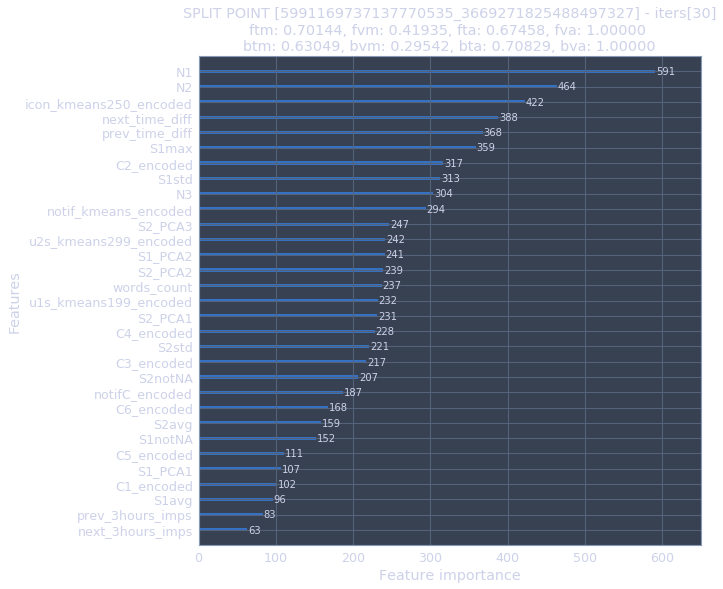

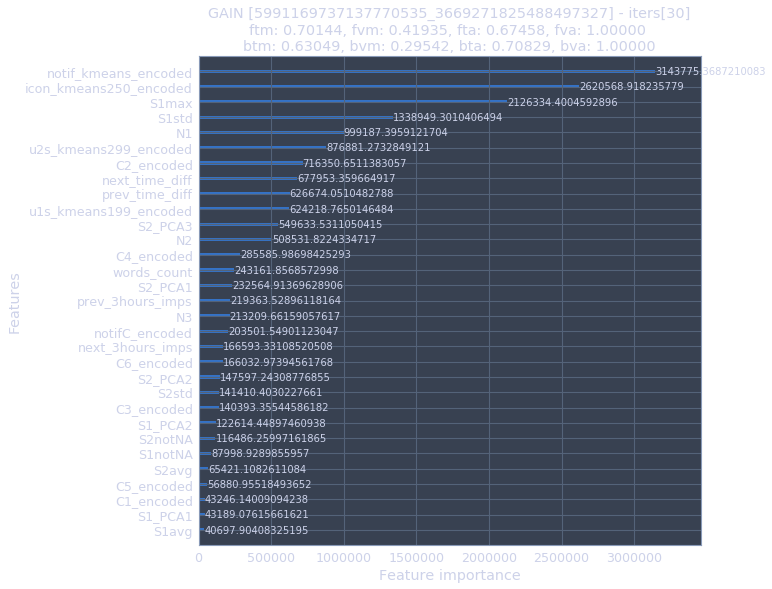

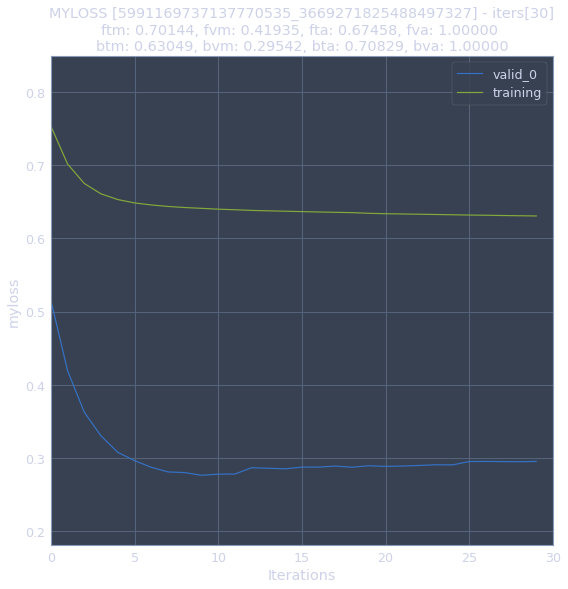

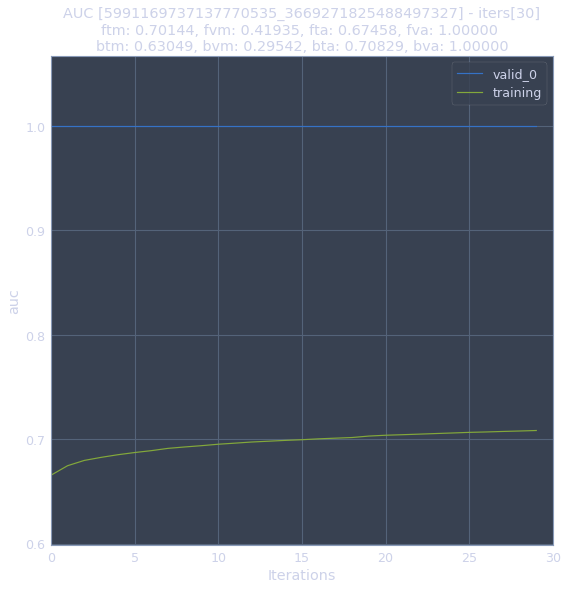

In [43]:
plots_and_info(savefigs=False)

[('num_leaves', 154), ('train_metric', '+'), ('metric', 'auc'), ('boosting', 'gbdt'), ('bagging_freq', 4), ('verbose', 1), ('task', 'train'), ('bagging_fraction', 0.9), ('learning_rate', 0.15), ('objective', 'none'), ('max_depth', 11), ('feature_fraction', 0.8)]
 - iters[17]
ftm: 0.75513, fvm: 0.56574, fta: 0.74384, fva: 1.00000 
btm: 0.59730, bvm: 0.34471, bta: 0.75897, bva: 1.00000


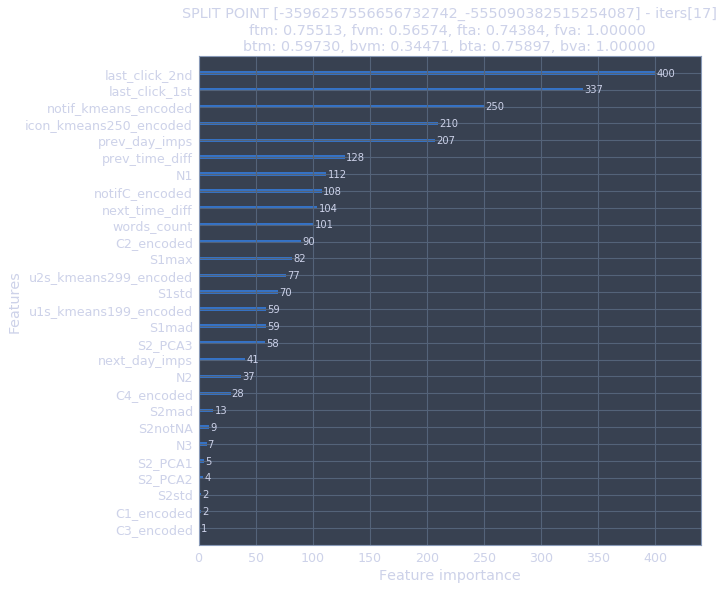

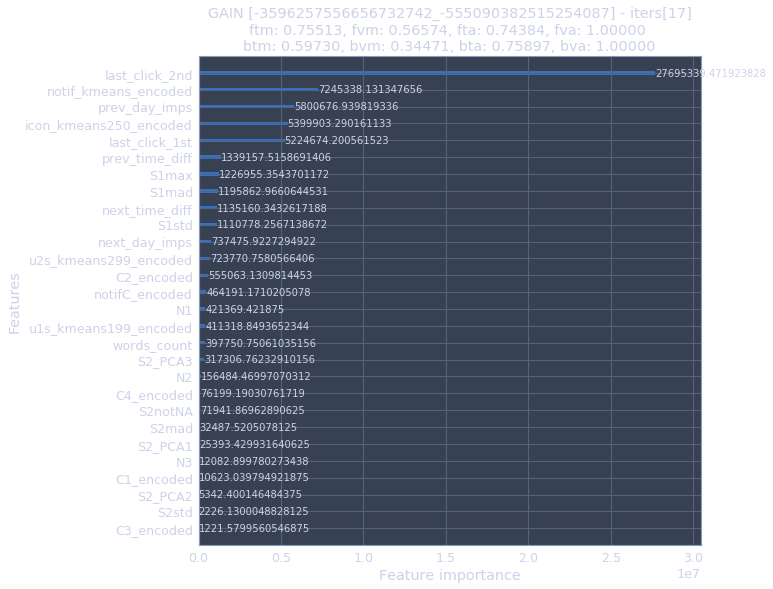

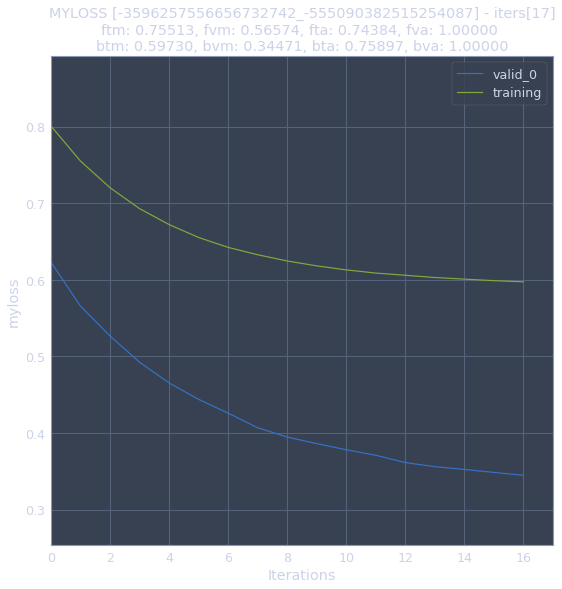

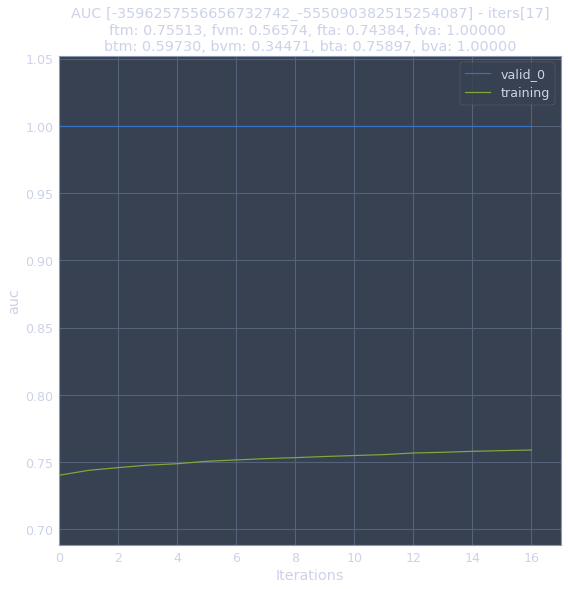

In [57]:
plots_and_info(savefigs=False)

[('num_leaves', 249), ('train_metric', '+'), ('metric', 'auc'), ('boosting', 'gbdt'), ('bagging_freq', 3), ('verbose', 1), ('max-bin', 420), ('task', 'train'), ('bagging_fraction', 0.74), ('learning_rate', 0.3), ('objective', 'none'), ('max_depth', 12), ('feature_fraction', 0.83)]
 - iters[30]
ftm: 0.71483, fvm: 0.44597, fta: 0.67394, fva: 1.00000 
btm: 0.63410, bvm: 0.24890, bta: 0.70311, bva: 1.00000


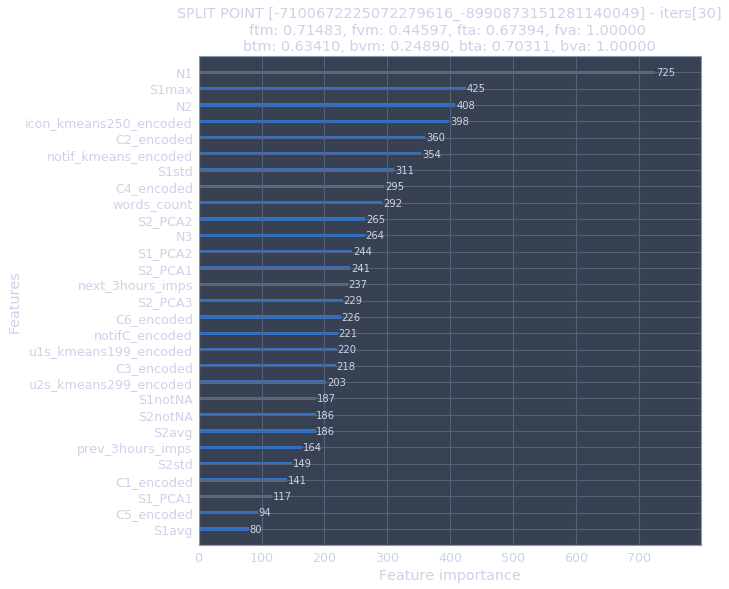

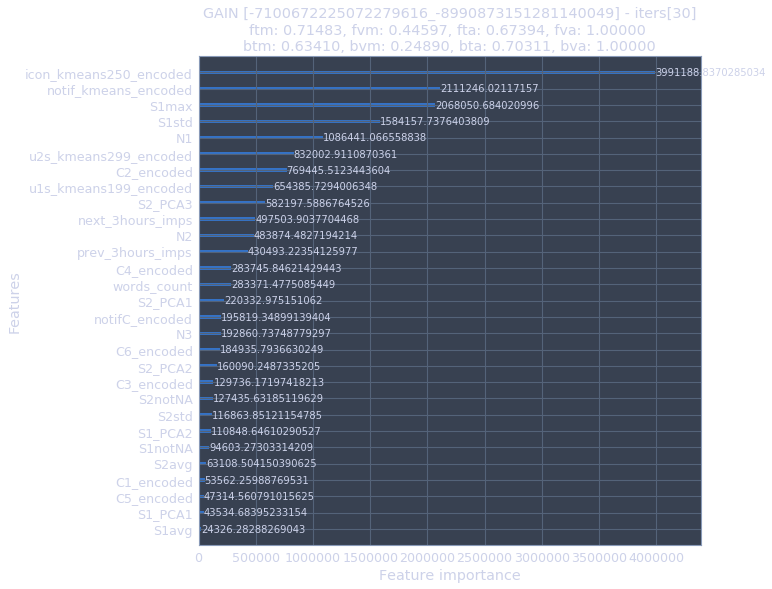

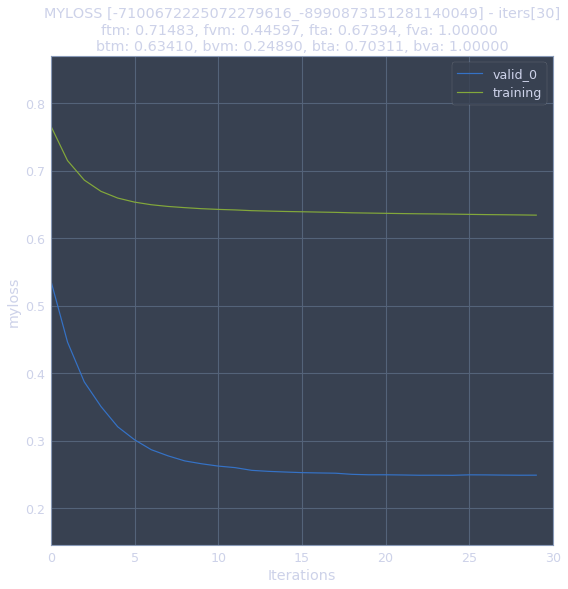

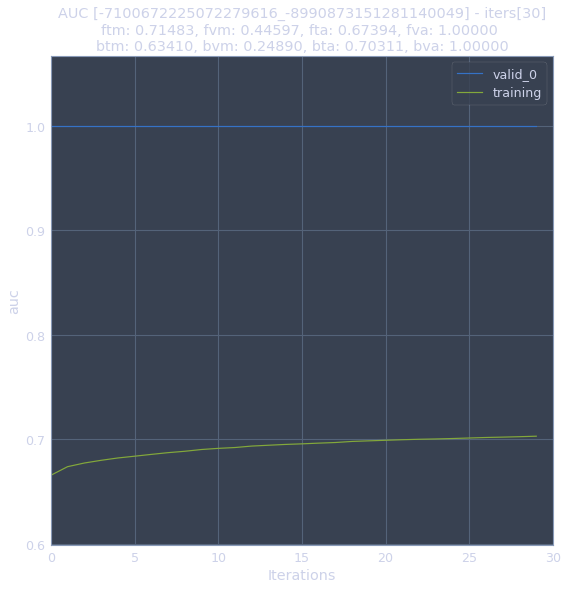

In [29]:
plots_and_info(savefigs=False)

In [ ]:
plots_and_info(savefigs=True)

## Save leafs

In [84]:
if split_pathway:
    trn_leafs = gbm.predict(X_trn, pred_leaf=True)
    trn_leafs_df = pd.DataFrame(trn_leafs)
    deca_save(trn_leafs_df, 'trn_gbdt_hist2.leafs')

    val_leafs = gbm.predict(X_val, pred_leaf=True)
    val_leafs_df = pd.DataFrame(val_leafs)
    deca_save(val_leafs_df, 'val_gbdt_hist2.leafs')
#     del trn_leafs, trn_leafs_df, val_leafs, val_leafs_df
else:
    ftrn_leafs1 = gbm.predict(X_ftrn[:58403133], pred_leaf=True)
    ftrn_leafs2 = gbm.predict(X_ftrn[58403133:], pred_leaf=True)
    ftrn_leafs = np.vstack([ftrn_leafs1, ftrn_leafs2])
    ftrn_leafs_df = pd.DataFrame(ftrn_leafs)
    deca_save(ftrn_leafs_df, 'ftrn_gbdt_hist_6.leafs')


    tst_leafs = gbm.predict(X_tst, pred_leaf=True)
    tst_leafs_df = pd.DataFrame(tst_leafs)
    deca_save(tst_leafs_df, 'tst_gbdt_hist_6.leafs')
    del ftrn_leafs1, ftrn_leafs2, ftrn_leafs, tst_leafs, ftrn_leafs_df, tst_leafs_df

saving data_hdf/_ftrn_gbdt_hist_6.leafs.h5... OK (21.6s)
saving data_hdf/_tst_gbdt_hist_6.leafs.h5... OK (2.3s)


In [ ]:
gc.collect()

## PLOTS

In [28]:
def plots_and_info(savefigs=True):
    param_hash = hash(frozenset(params.items()))
    featnames = ', '.join(sorted(gbm.feature_name()))
    feat_hash = hash(featnames)

    num_iters = len(evals_result['training']['myloss'])
    print(params.items())

    first_train_auc = evals_result['training']['auc'][1]
    best_train_auc = evals_result['training']['auc'][-1]
    first_train_myloss = evals_result['training']['myloss'][1]
    best_train_myloss = evals_result['training']['myloss'][-1]

    first_valid_auc = evals_result['valid_0']['auc'][1]
    best_valid_auc = evals_result['valid_0']['auc'][-1]
    first_valid_myloss = evals_result['valid_0']['myloss'][1]
    best_valid_myloss = evals_result['valid_0']['myloss'][-1]

    perf_title = ' - iters[{}]\nftm: {:.5f}, fvm: {:.5f}, fta: {:.5f}, fva: {:.5f} \nbtm: {:.5f}, bvm: {:.5f}, bta: {:.5f}, bva: {:.5f}'.format(
        num_iters,
        first_train_myloss, first_valid_myloss, first_train_auc, first_valid_auc,
        best_train_myloss, best_valid_myloss, best_train_auc, best_valid_auc,
    )

    print(perf_title)

    implot = lgb.plot_importance(gbm, figsize=(9, 9), title='SPLIT POINT [{}_{}]{}'.format(param_hash, feat_hash, perf_title))
    implot2 = lgb.plot_importance(gbm, figsize=(9, 9), importance_type='gain', title='GAIN [{}_{}]{}'.format(param_hash, feat_hash, perf_title))
    implot3 = lgb.plot_metric(evals_result, metric='myloss', figsize=(9, 9), title='MYLOSS [{}_{}]{}'.format(param_hash, feat_hash, perf_title))
    implot4 = lgb.plot_metric(evals_result, metric='auc', figsize=(9, 9), title='AUC [{}_{}]{}'.format(param_hash, feat_hash, perf_title))

    if savefigs:
        implot.get_figure().savefig('/home/nima_mohammadi/Pushe/GBDT_results/imp_split_{}__{}.pdf'.format(param_hash, feat_hash))
        implot2.get_figure().savefig('/home/nima_mohammadi/Pushe/GBDT_results/imp_gain_{}__{}.pdf'.format(param_hash, feat_hash))
        implot3.get_figure().savefig('/home/nima_mohammadi/Pushe/GBDT_results/loss_my_{}__{}.pdf'.format(param_hash, feat_hash))
        implot4.get_figure().savefig('/home/nima_mohammadi/Pushe/GBDT_results/loss_auc_{}__{}.pdf'.format(param_hash, feat_hash))

        with open('/home/nima_mohammadi/Pushe/GBDT_results/params_{}.txt'.format(param_hash), 'w') as fo:
            fo.write(json.dumps(params, indent=4))
        with open('/home/nima_mohammadi/Pushe/GBDT_results/feats_{}.txt'.format(feat_hash), 'w') as fo:
            fo.write('\n'.join(sorted(gbm.feature_name())))
        with open('/home/nima_mohammadi/Pushe/GBDT_results/learning_{}_{}.txt'.format(param_hash, feat_hash), 'w') as fo:
            fo.write(json.dumps(evals_result, indent=4))

In [ ]:
plots_and_info(savefigs=False)

In [ ]:
plots_and_info(savefigs=False)

In [ ]:
plots_and_info(savefigs=False)

In [ ]:
plots_and_info(savefigs=False)

In [ ]:
plots_and_info(savefigs=True)

In [ ]:
from sklearn import metrics

In [ ]:
y_pred = gbm.predict(X_val)
print(calc_loss(y_val, y_pred) )
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
print(metrics.auc(fpr, tpr))

# XGBoost

In [ ]:
del lgb_train, lgb_eval, gbm
gc.collect()

In [85]:
del lgb_ftrain, lgb_test, gbm
gc.collect()

0

In [86]:
import xgboost as xgb

In [87]:
if split_pathway:
    d_trn = xgb.DMatrix(X_trn, y_trn, feature_names=features)
    d_val = xgb.DMatrix(X_val, y_val, feature_names=features)
else:
    d_ftrn = xgb.DMatrix(X_ftrn, y_ftrn, feature_names=features)
    d_tst = xgb.DMatrix(X_tst, y_tst, feature_names=features)

In [88]:
def my_xgb_logistic_obj(y_hat, dtrain):
    y = dtrain.get_label()
    p = y_hat 
    grad = 4 * p * y + p - 5 * y
    hess = (4 * y + 1) * (p * (1.0 - p))
    return grad, hess

def my_xgb_err_rate(y_hat, dtrain):
    y = dtrain.get_label()
    y_hat = np.clip(y_hat, 10e-7, 1-10e-7)
    loss_fn = y*np.log(y_hat)
    loss_fp = (1.0 - y)*np.log(1.0 - y_hat)
    return 'myloss', np.sum(-(5*loss_fn+loss_fp))/len(y)

In [89]:
xgb_pars = {
    'eta': 0.36,
    'gamma': 0.00001,
    'max_depth': 8,
    'min_child_weight': 3,
#     'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 0.4,
    'colsample_bylevel': 0.7,
#     'lambda': 1,
#     'alpha': 0,
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
#     'nthread': 40,
    'seed': 42,
    'silent': 1,
}

In [ ]:
num_round = 28
if split_pathway:
    model_trn = xgb.train(xgb_pars, d_trn, num_round, evals=[(d_trn, 'train'), (d_val, 'validation')],
                      obj=my_xgb_logistic_obj, feval=my_xgb_err_rate, verbose_eval=1)
else:
    model_trn = xgb.train(xgb_pars, d_ftrn, num_round, evals=[(d_ftrn, 'train')],
                      obj=my_xgb_logistic_obj, feval=my_xgb_err_rate, verbose_eval=1)

[0]	train-auc:0.6667	train-myloss:0.750481
[1]	train-auc:0.675969	train-myloss:0.698316
[2]	train-auc:0.681446	train-myloss:0.67202
[3]	train-auc:0.684578	train-myloss:0.658444
[4]	train-auc:0.686928	train-myloss:0.651066
[5]	train-auc:0.690015	train-myloss:0.646443
[6]	train-auc:0.692116	train-myloss:0.643504
[7]	train-auc:0.693747	train-myloss:0.641762
[8]	train-auc:0.695181	train-myloss:0.640367
[9]	train-auc:0.6968	train-myloss:0.639134
[10]	train-auc:0.697976	train-myloss:0.638176
[11]	train-auc:0.698789	train-myloss:0.637517
[12]	train-auc:0.699792	train-myloss:0.63673
[13]	train-auc:0.700483	train-myloss:0.63619
[14]	train-auc:0.701507	train-myloss:0.635443


In [ ]:
5

In [ ]:
ax = xgb.plot_importance(model_trn, importance_type='gain')
ax.figure.set_size_inches(10, 10)

In [ ]:
ax = xgb.plot_importance(model_trn)
ax.figure.set_size_inches(10, 10)

In [ ]:
ax = xgb.plot_importance(model_trn)
ax.figure.set_size_inches(10, 10)

In [ ]:
sigm = lambda yp: 1.0 / (1.0 + np.exp(-yp))
if split_pathway:
    y_pred = model_trn.predict(d_val)
    np.savetxt('/media/ramdisk/val_preds_gbdt_xgb_cand.txt', y_pred, '%.10f')
    print('VAL:', calc_loss(d_val.get_label(), y_pred), False)
else:
    y_pred = model_trn.predict(d_tst)
    print('TEST:', calc_loss(d_tst.get_label(), y_pred, False))
    np.savetxt('/media/ramdisk/test_preds_gbdt_xgb_cand.txt', y_pred, '%.10f')
#     print('TEST')

In [ ]:
pred_val = model_trn.predict(d_val)

In [ ]:
calc_loss(d_val.get_label(), pred_val)

In [ ]:
if split_pathway:
    trn_leafs = model_trn.predict(d_trn, pred_leaf=True)
    trn_leafs_df = pd.DataFrame(trn_leafs)
    deca_save(trn_leafs_df, 'trn_xgb_gbdt_hist.leafs')
    
    val_leafs = model_trn.predict(d_val, pred_leaf=True)
    val_leafs_df = pd.DataFrame(val_leafs)
    deca_save(val_leafs_df, 'val_xgb_gbdt_hist.leafs')
else:
    ftrn_leafs = model_trn.predict(d_ftrn, pred_leaf=True)
    ftrn_leafs_df = pd.DataFrame(ftrn_leafs)
    deca_save(ftrn_leafs_df, 'ftrn_xgb_gbdt_hist_1.leafs')
    
    tst_leafs = model_trn.predict(d_tst, pred_leaf=True)
    tst_leafs_df = pd.DataFrame(tst_leafs)
    deca_save(tst_leafs_df, 'tst_xgb_gbdt_hist_1.leafs')

In [ ]:
val_leafs = model_trn.predict(d_val, pred_leaf=True)
val_leafs_df = pd.DataFrame(val_leafs)
deca_save(val_leafs_df, 'val_xgb_gbdt.leafs')

# Junk

In [ ]:
from sklearn import metrics

In [ ]:
y_pred = gbm.predict(X_val)

In [ ]:
"%f" % calc_loss(y_val, y_pred)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)

In [ ]:
metrics.auc(fpr, tpr)

In [ ]:
y_pred = gbm.predict(X_trn)
"%f" % calc_loss(y_trn, y_pred)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_trn, y_pred)
metrics.auc(fpr, tpr)

In [ ]:
y_pred.shape, y_trn.shape

In [ ]:
y_pred = gbm.predict(X_trn)
"%f" % calc_loss(y_trn, y_pred)

In [ ]:
y_pred2 = y_pred.copy()

In [ ]:
"%f" % calc_loss(y_val, np.clip(y_pred, 1e-2, 1-1e-3))

In [ ]:
"%f" % my_err_rate(y_pred, y_val)

In [ ]:
"%f" % calc_loss(y_val, y_pred+0.025)

In [ ]:
#lgb.plot_tree(gbm, figsize=(400, 60))

In [ ]:
zip(features, gbm.feature_importance())

In [ ]:
tst_leafs = gbm.predict(X_tst, pred_leaf=True)
tst_leafs_df = pd.DataFrame(tst_leafs)
deca_save(tst_leafs_df, 'tst_gbdt.leafs')

In [ ]:
tst_preds = tst_leafs = gbm.predict(X_tst)
np.savetxt('/media/ramdisk/preds_gbdt.txt', np.clip(tst_preds, 10e-10, 1-10e-10), '%.10f')

In [ ]:
tst_preds[:10]

In [ ]:
features[3]

In [ ]:
y_pred = gbm.predict(X_val)#, num_iteration=gbm.best_iteration)
"%f" % calc_loss(y_val, y_pred)

In [ ]:
y_pred = gbm.predict(X_trn)#, num_iteration=gbm.best_iteration)
"%f" % calc_loss_default(y_trn, y_pred)

In [ ]:
def calc_loss(y, yp):
#     yp = 1.0 / (1.0 + np.exp(-yp))
    yp = np.clip(yp, 1e-7, 1-1e-7)
    loss_fn = y*np.log(yp)
    loss_fp = (1-y)*np.log(1-yp)
    return np.sum(-(5*loss_fn+loss_fp))/y.shape[0]

In [ ]:
def calc_loss_default(y, yp):
#     yp = 1.0 / (1.0 + np.exp(-yp))
    yp = np.clip(yp, 1e-7, 1-1e-7)
    loss_fn = y*np.log(yp)
    loss_fp = (1-y)*np.log(1-yp)
    return np.sum(-(loss_fn+loss_fp))/y.shape[0]

In [ ]:
d_trn = xgb.DMatrix(X_trn, y_trn, feature_names=features)
d_val = xgb.DMatrix(X_val, y_val, feature_names=features)

In [ ]:
del X_trn, X_val, y_trn, y_val
gc.collect()

In [ ]:
def deca_logistic_obj(y_hat, dtrain):
    y = dtrain.get_label()
    p = 1.0 / (1.0 + np.exp(-y_hat))
    grad = 4 * p * y + p - 5 * y
    hess = (4 * y + 1) * (p * (1.0 - p))
    return grad, hess

In [ ]:
def deca_err_rate(y_hat, dtrain):
    y = dtrain.get_label()
#     preds = 1.0 / (1.0 + np.exp(-preds))
    y_hat = np.clip(y_hat, 1e-7, 1-1e-7)
    loss_fn = y*np.log(y_hat)
    loss_fp = (1.0 - y)*np.log(1.0 - y_hat)
    return 'error', np.sum(-(5*loss_fn+loss_fp))/len(y)

In [ ]:
xgb_pars = {
    'eta': 0.2,
#     'gamma': 0.5,
    'max_depth': 6,
#     'min_child_weight': 1,
#     'max_delta_step': 0,
#     'subsample': 1,
#     'colsample_bytree': 0.5,
#     'colsample_bylevel': 0.5,
#     'lambda': 1,
#     'alpha': 0,
    'tree_method': 'hist',
    'objective': 'binary:logistic',
#     'eval_metric': 'auc',
#     'nthread': 40,
    'seed': 42,
    'silent': 1,
}

In [ ]:
model_trn = xgb.train(xgb_pars, d_trn, num_round, evals=[(d_trn, 'train'), (d_val, 'validation')],
                      obj=deca_logistic_obj, feval=deca_asym_logloss, verbose_eval=1)

In [ ]:
model_trn = xgb.train(xgb_pars, d_trn, 15, evals=[(d_trn, 'train'), (d_val, 'validation')],
                      feval=deca_asym_logloss, verbose_eval=1)

In [ ]:
model_trn = xgb.train(xgb_pars, d_trn, 3, evals=[(d_trn, 'train'), (d_val, 'validation')],
                      obj=deca_logistic_obj, feval=deca_err_rate, verbose_eval=1)

In [ ]:
xgb_pars = {
    'eta': 0.2,
    'max_depth': 6,
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42,
    'silent': 1,
}

In [ ]:
model_trn = xgb.train(xgb_pars, d_trn, 10, evals=[(d_trn, 'train'), (d_val, 'validation')],
                      obj=deca_logistic_obj, feval=deca_err_rate, verbose_eval=1)

In [ ]:
model_trn = xgb.train(xgb_pars, d_trn, 10, evals=[(d_trn, 'train'), (d_val, 'validation')],
                      obj=deca_logistic_obj, feval=deca_err_rate, verbose_eval=1)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
xgb.to_graphviz(model_trn, num_trees=2)

In [ ]:
xgb.plot_importance(model_trn)

In [ ]:
tic = time.time()
model_trn = xgb.train(xgb_pars, d_val, num_round, evals=[(d_val, 'validation')],
                      obj=deca_logistic_obj, feval=deca_asym_logloss, verbose_eval=1)
time.time() - tic

In [ ]:
xgb_pars['tree_method'] = 'gpu_hist'
tic = time.time()
model_trn = xgb.train(xgb_pars, d_trn, num_round, evals=[(d_trn, 'train')],
                      obj=deca_logistic_obj, feval=deca_asym_logloss, verbose_eval=1)
time.time() - tic

In [ ]:
xgb_pars = {
#     'eta': 0.2,
#     'gamma': 0.5,
#     'max_depth': 6,
#     'min_child_weight': 1,
#     'max_delta_step': 0,
#     'subsample': 1,
#     'colsample_bytree': 0.5,
#     'colsample_bylevel': 0.5,
#     'lambda': 1,
#     'alpha': 0,
    'tree_method': 'hist',
    'objective': 'binary:logistic',
#     'eval_metric': 'auc',
#     'nthread': 40,
    'seed': 42,
    'silent': 1,
}

In [ ]:
model_trn = xgb.train(xgb_pars, d_trn, 3, evals=[(d_trn, 'train'), (d_val, 'validation')],
                      obj=deca_logistic_obj, feval=deca_asym_logloss, verbose_eval=1)

In [ ]:
pred_train = model_trn.predict(d_trn)

In [ ]:
calc_loss(d_trn.get_label(), pred_train)

In [ ]:
calc_loss_default(d_trn.get_label(), pred_train)

In [ ]:
calc_loss(d_trn.get_label(), pred_train)

In [ ]:
deca_asym_logloss(pred_train, d_trn)

In [ ]:
pred_train.max()

In [ ]:
def calc_loss(y, yp):
    yp = np.clip(yp, 1e-7, 1-1e-7)
    loss_fn = y*np.log(yp)
    loss_fp = (1-y)*np.log(1-yp)
    return np.sum(-(5*loss_fn+loss_fp))/y.shape[0]

In [ ]:
def calc_loss_default(y, yp):
    yp = np.clip(yp, 1e-7, 1-1e-7)
    loss_fn = y*np.log(yp)
    loss_fp = (1-y)*np.log(1-yp)
    return np.sum(-(loss_fn+loss_fp))/y.shape[0]